# Causal Inference over a Causal Graph

In [1]:
from IPython.display import clear_output

In [2]:
!pip install dowhy
!pip install gcastle
!pip install econml
!pip install shap
clear_output()

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dowhy import CausalModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import clear_output

In [4]:
np.random.seed(0)

## 1. Synthetic data generation

In [95]:
# Note (1): lv0 features may affect both targets an other features of lv1
# Note (2): col_targets are leaf nodes that do not affect oneanother

SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(SAMPLE_SIZE)
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3
    }
    )
df.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,2024-01-01,0.949643,0.910061,0.952722,0.349009,0.942703,0.117221,0.512874,0.440741,-0.348697
1,2024-01-02,0.175464,0.695970,0.500312,0.487472,0.395909,0.410712,0.430848,0.444035,0.130338
2,2024-01-03,0.629889,0.283644,0.295696,0.729561,0.378075,0.090849,0.543557,0.266913,-0.078731
3,2024-01-04,0.073799,0.348536,0.763961,0.122768,0.493222,0.309748,0.326722,0.295771,0.289033
4,2024-01-05,0.307543,0.823404,0.824912,0.284127,0.640782,0.247490,0.407817,0.434488,-0.051445


## 2. GCM API

### 2.1. Define the Causal Graph

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [97]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [98]:
# Define graph dependencies
edges = [
    ('col_feature1_lv0', 'col_feature4_lv1'),
    ('col_feature1_lv0', 'col_feature5_lv1'),
    ('col_feature1_lv0', 'col_target1'),
    ('col_feature1_lv0', 'col_target2'),
    ('col_feature1_lv0', 'col_target3'),

    ('col_feature2_lv0', 'col_feature5_lv1'),
    ('col_feature2_lv0', 'col_target1'),
    ('col_feature2_lv0', 'col_target2'),
    ('col_feature2_lv0', 'col_target3'),

    ('col_feature3_lv0', 'col_feature5_lv1'),
    ('col_feature3_lv0', 'col_feature6_lv1'),
    ('col_feature3_lv0', 'col_target1'),

    ('col_feature4_lv1', 'col_target1'),

    ('col_feature5_lv1', 'col_target2'),
    ('col_feature5_lv1', 'col_target3'),

    ('col_feature6_lv1', 'col_target2')
    ]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

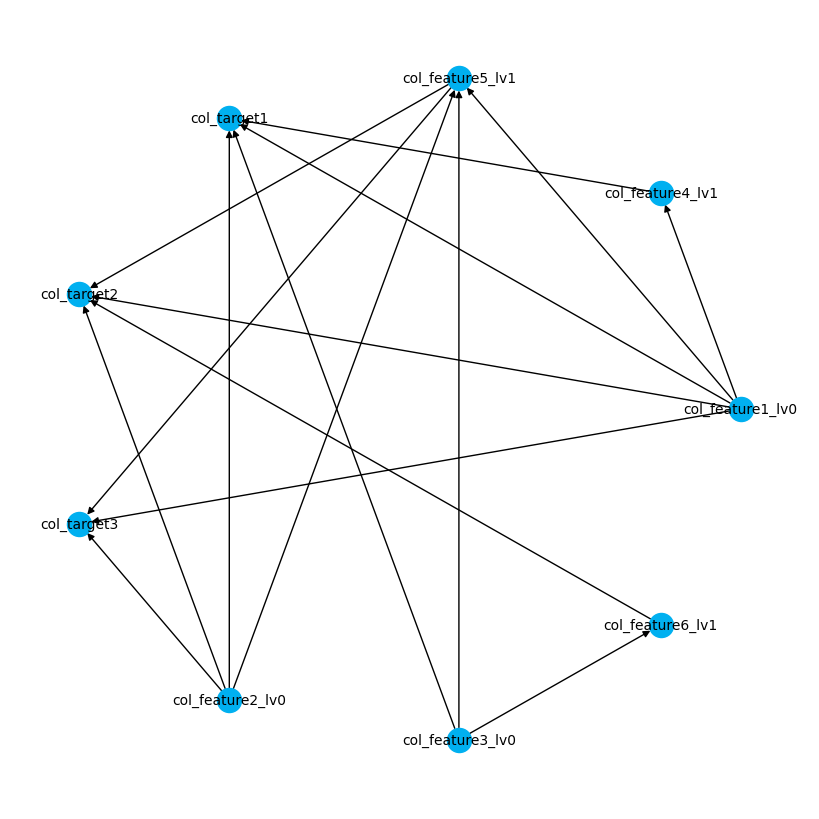

In [99]:
'''
nx.draw(
    graph_nx,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
'''
# larger figure size
plt.figure(3,figsize=(8,8))
pos = nx.circular_layout(graph_nx)
nx.draw(
    graph_nx,
    pos,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
plt.show()

In [100]:
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']

### 2.2. Model the Graph

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/graphical_causal_model_types.html

#### Manually assign causal mechanism

In [101]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Set lv0/root nodes to empirical distribution
for col_lv0 in list_cols_lv0:
  causal_model.set_causal_mechanism(col_lv0, gcm.EmpiricalDistribution())

# Nodes in the middle and leaf nodes are modeled through a linear model.
for col_not_lv0 in list_cols_middle + list_cols_target:
  causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 166.28it/s]


In [102]:
# Get arrow strength
# By default, arrow_strength employs KL divergence for measuring the arrow strength for categorical target
# Results in terms of the ouctome variable variance chnage given we remove the edge from the source variable
gcm.arrow_strength(causal_model, 'col_target1')

{('col_feature1_lv0', 'col_target1'): 0.0033318479968330013,
 ('col_feature2_lv0', 'col_target1'): 0.0007964226903274207,
 ('col_feature3_lv0', 'col_target1'): 0.000871843098894261,
 ('col_feature4_lv1', 'col_target1'): 0.002894865593046432}

In [109]:
# Check proportions
'''
col_feature1_lv0 should be ~2xmin_ref (by itself, plus 0.3*0.2 = 0.06->~0.5xmin_ref -> 2.5xmin_ref aprox through col_feature4_lv1)
col_feature2_lv0 should be ~1xmin_ref
col_feature3_lv0 should be ~1xmin_ref
col_feature4_lv1 should be 0.67*0.3=0.2 -> ~2xmin_ref (by itself)
'''
dct_strength = gcm.arrow_strength(causal_model, 'col_target1')
ref_val = min(dct_strength.values())
for key, value in dct_strength.items():
  print(key)
  print(value)
  print("Proportion: ", np.round(value/ref_val, 4))

('col_feature1_lv0', 'col_target1')
0.0034312421802689293
Proportion:  4.3348
('col_feature2_lv0', 'col_target1')
0.0007915548222814901
Proportion:  1.0
('col_feature3_lv0', 'col_target1')
0.000854629482353157
Proportion:  1.0797
('col_feature4_lv1', 'col_target1')
0.002859721856462425
Proportion:  3.6128


In [13]:
# For all target columns
for col_target in list_cols_target:
  print(gcm.arrow_strength(causal_model, col_target))

{('col_feature1_lv0', 'col_target1'): 0.003441337348267947, ('col_feature2_lv0', 'col_target1'): 0.0008996472746462906, ('col_feature3_lv0', 'col_target1'): 0.0007456904868324028, ('col_feature4_lv1', 'col_target1'): 0.0032991635332235963}
{('col_feature1_lv0', 'col_target2'): 0.0008458453706171806, ('col_feature2_lv0', 'col_target2'): 0.0036816966885490584, ('col_feature5_lv1', 'col_target2'): 0.00030324951422116186, ('col_feature6_lv1', 'col_target2'): 0.004867263764529577}
{('col_feature1_lv0', 'col_target3'): 0.007472685463741839, ('col_feature2_lv0', 'col_target3'): 0.007746539457511637, ('col_feature5_lv1', 'col_target3'): 5.310245480527478e-05}


In [14]:
# Reference datapoint
X_ref = df.head(1).copy().drop(columns=['col_date'])
X_ref

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,0.548814,0.59288,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524


#### Counterfactual examples

In [15]:
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: X_ref[col_lvl0].values[0] + ref_increase},
        observed_data=X_ref
        )
  )
  df_exp = (
      df_exp
      .T
      .reset_index()
      .rename(columns={0:'counter_value'})
      .merge(
          X_ref
          .T
          .reset_index()
          .rename(columns={0:'ref_value'})
          )
      .sort_values(by=['index'])
  )
  df_exp['feature_importance'] = df_exp['counter_value'] - df_exp['ref_value']
  df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)

**********************************************************************
Increase of 1 in col_feature1_lv0


,index,counter_value,ref_value,feature_importance
1,col_feature2_lv0,0.592880,0.592880,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.569056,0.387118,0.181938
4,col_feature5_lv1,0.958803,0.658956,0.299848
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.695056,0.441297,0.253759
8,col_target2,0.533463,0.403767,0.129697
7,col_target3,-0.496433,-0.179524,-0.316910


**********************************************************************
**********************************************************************
Increase of 1 in col_feature2_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,0.757298,0.658956,0.098342
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.541520,0.441297,0.100223
8,col_target2,0.615725,0.403767,0.211959
7,col_target3,-0.472677,-0.179524,-0.293153


**********************************************************************
**********************************************************************
Increase of 1 in col_feature3_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
1,col_feature2_lv0,0.592880,0.592880,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,1.155218,0.658956,0.496262
5,col_feature6_lv1,0.303814,0.260644,0.043170
6,col_target1,0.537041,0.441297,0.095745
8,col_target2,0.471526,0.403767,0.067759
7,col_target3,-0.208497,-0.179524,-0.028974


**********************************************************************


In [16]:
'''
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
# Alternative -> set the counter value t 0 in the ref datapoint
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  X_iter = X_ref.copy()
  X_iter[col_lvl0] = 0


  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: ref_increase},
        observed_data=X_iter
        )
  )
  #df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)
'''
print()

#### Interventional examples

In [17]:
# Interventional examples; what happens if we fix the value of a node to a target reference?
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        #'col_feature2_lv0': lambda x: 1,
        #'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,1,0.042454,0.464490,0.598023,0.577110,0.097388,0.580157,0.006767,0.301589
1,1,0.193236,0.256633,0.413954,0.467226,0.021544,0.464229,0.023821,0.234606
2,1,0.826805,0.905001,0.484040,0.924125,0.508325,0.524289,-0.237963,0.603720
3,1,0.628314,0.102020,0.385802,0.432293,0.106096,0.510178,-0.544302,0.323228
4,1,0.148039,0.600471,0.419415,0.666921,0.546148,0.565448,-0.378361,0.451785


In [18]:
# Interventional examples; what happens if we fix the value of a node to a target reference?
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        'col_feature2_lv0': lambda x: 1,
        'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,1,1,1,0.307782,0.973772,0.101769,0.627415,-0.457187,0.517658
1,1,1,1,0.821381,0.951584,0.484407,0.701706,-0.433425,0.650406
2,1,1,1,0.296516,0.962056,0.523160,0.665821,-0.208631,0.643060
3,1,1,1,0.570517,0.914573,0.139531,0.741946,-0.412615,0.511988
4,1,1,1,0.334856,0.985960,0.477565,0.655285,-0.483872,0.681949


#### Confidence Intervals

In [19]:
'''
# Confidence intervals
col_root = 'col_feature1_lv0'
col_check = 'col_feature4_lv1'
X_new = X_ref.copy()
X_new[col_root] = X_ref[col_root].values[0] + ref_increase
gcm.confidence_intervals(
    lambda: gcm.distribution_change(
        causal_model,
        X_ref,
        X_new,
        target_node=col_check
        )
    )
'''
print()

In [20]:
# Confidence intervals
list_results = []
for col_check in list_cols_middle:
  print("*"*70)
  print(f"Analysis for {col_check}")
  strength_median, strength_intervals = gcm.confidence_intervals(
      gcm.fit_and_compute(gcm.arrow_strength,
                          causal_model,
                          bootstrap_training_data=df,
                          target_node=col_check))
  print(strength_median, strength_intervals)
  clear_output()
  list_results.append((strength_median, strength_intervals))
  print("*"*70)

**********************************************************************


In [21]:
for item in list_results:
  print(item)

({('col_feature1_lv0', 'col_feature4_lv1'): 0.003028218518641654}, {('col_feature1_lv0', 'col_feature4_lv1'): array([0.0024643 , 0.00346581])})
({('col_feature1_lv0', 'col_feature5_lv1'): 0.0075681235399353616, ('col_feature2_lv0', 'col_feature5_lv1'): 0.0008703435470851925, ('col_feature3_lv0', 'col_feature5_lv1'): 0.02028316126964715}, {('col_feature1_lv0', 'col_feature5_lv1'): array([0.00732076, 0.00794257]), ('col_feature2_lv0', 'col_feature5_lv1'): array([0.00082227, 0.00093359]), ('col_feature3_lv0', 'col_feature5_lv1'): array([0.01944245, 0.02089513])})
({('col_feature3_lv0', 'col_feature6_lv1'): 0.00017357378400434379}, {('col_feature3_lv0', 'col_feature6_lv1'): array([4.98883744e-05, 4.24765972e-04])})


In [22]:
# CI alternative (withoout retraining)
# Confidence intervals
list_results = []
for col_check in list_cols_middle:
  print("*"*70)
  print(f"Analysis for {col_check}")
  strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.arrow_strength,
                           causal_model,
                           target_node=col_check))

  print(strength_median, strength_intervals)
  clear_output()
  list_results.append((strength_median, strength_intervals))
  print("*"*70)

**********************************************************************


In [23]:
for item in list_results:
  print(item)

({('col_feature1_lv0', 'col_feature4_lv1'): 0.0027045240360083953}, {('col_feature1_lv0', 'col_feature4_lv1'): array([0.00256338, 0.00303298])})
({('col_feature1_lv0', 'col_feature5_lv1'): 0.007604575971903919, ('col_feature2_lv0', 'col_feature5_lv1'): 0.0008649801543516986, ('col_feature3_lv0', 'col_feature5_lv1'): 0.020328638584296174}, {('col_feature1_lv0', 'col_feature5_lv1'): array([0.00744462, 0.00770864]), ('col_feature2_lv0', 'col_feature5_lv1'): array([0.00083392, 0.0008836 ]), ('col_feature3_lv0', 'col_feature5_lv1'): array([0.01984381, 0.02068258])})
({('col_feature3_lv0', 'col_feature6_lv1'): 0.00017295873316008724}, {('col_feature3_lv0', 'col_feature6_lv1'): array([0.00010092, 0.00034827])})


#### New predictions

In [25]:
# New predictions
'''
col_target_check =

col_root = 'col_feature1_lv0'
col_check = 'col_feature4_lv1'
X_new = X_ref.copy()
X_new[col_root] = X_ref[col_root].values[0] + ref_increase
gcm.distribution_change(
  causal_model,
  X_ref,
  X_new,
  target_node=col_check
  )
'''

# Reference input nodes
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
X_pred = gcm.interventional_samples(
    causal_model,
    dct_input,
    num_samples_to_draw=1
)
display(X_pred)
display(X_pred[list_cols_target])
display(y_test)
'''
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        'col_feature2_lv0': lambda x: 1,
        'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()
'''
print()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,0.605043,0.605043,0.605043,0.764636,0.609623,0.540473,0.545734,-0.35327,0.49025


,col_target1,col_target2,col_target3
0,0.545734,0.49025,-0.35327


,col_target1,col_target2,col_target3
4,0.353248,0.163123,-0.147083


In [26]:
X_ref

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,0.548814,0.59288,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524


In [47]:
# Reference datapoints
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input_base = {col_input: lambda x: 0 for col_input in list(X_test.columns)}

# Average causal effect
idx_check = 0
estim_effect = gcm.average_causal_effect(
    causal_model,
    list_cols_target[idx_check],
    interventions_alternative=dct_input,
    interventions_reference=dct_input_base,
    num_samples_to_draw=1000 # Using a sampling
)
print(list_cols_target[idx_check])
print(y_test[list_cols_target[idx_check]].values[0], estim_effect)

col_target1
0.3532476440676608 0.2702212850190363


In [48]:
# Reference datapoints
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input_base = {col_input: lambda x: 0 for col_input in list(X_test.columns)}

# Average causal effect
idx_check = 0
estim_effect = gcm.average_causal_effect(
    causal_model,
    list_cols_target[idx_check],
    interventions_alternative=dct_input,
    interventions_reference=dct_input_base,
    observed_data=df # Using the original data
)
print(list_cols_target[idx_check])
print(y_test[list_cols_target[idx_check]].values[0], estim_effect)

col_target1
0.3532476440676608 0.2692565977159843


### 2.3. Model the Graph with known relationships

Here, we include some known relationships within the graph

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html

In [ ]:
import dowhy.gcm.ml.prediction_model

In [ ]:
class MyCustomModel(gcm.ml.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        return MyCustomModel(self.coefficient)

In [ ]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Set lv0/root nodes to empirical distribution
for col_lv0 in list_cols_lv0:
  causal_model.set_causal_mechanism(col_lv0, gcm.EmpiricalDistribution())

# Nodes in the middle and leaf nodes are modeled through a linear model.
for col_not_lv0 in list_cols_middle + list_cols_target:
  if col_not_lv0 != 'col_feature6_lv1':
    causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
  else:
    causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(MyCustomModel(0.05)))

gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 187.68it/s]


In [ ]:
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: X_ref[col_lvl0].values[0] + ref_increase},
        observed_data=X_ref
        )
  )
  df_exp = (
      df_exp
      .T
      .reset_index()
      .rename(columns={0:'counter_value'})
      .merge(
          X_ref
          .T
          .reset_index()
          .rename(columns={0:'ref_value'})
          )
      .sort_values(by=['index'])
  )
  df_exp['feature_importance'] = df_exp['counter_value'] - df_exp['ref_value']
  df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)

**********************************************************************
Increase of 1 in col_feature1_lv0


,index,counter_value,ref_value,feature_importance
1,col_feature2_lv0,0.592880,0.592880,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.569056,0.387118,0.181938
4,col_feature5_lv1,0.958803,0.658956,0.299848
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.695056,0.441297,0.253759
8,col_target2,0.533463,0.403767,0.129697
7,col_target3,-0.496433,-0.179524,-0.316910


**********************************************************************
**********************************************************************
Increase of 1 in col_feature2_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,0.757298,0.658956,0.098342
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.541520,0.441297,0.100223
8,col_target2,0.615725,0.403767,0.211959
7,col_target3,-0.472677,-0.179524,-0.293153


**********************************************************************
**********************************************************************
Increase of 1 in col_feature3_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
1,col_feature2_lv0,0.592880,0.592880,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,1.155218,0.658956,0.496262
5,col_feature6_lv1,0.310644,0.260644,0.050000
6,col_target1,0.537041,0.441297,0.095745
8,col_target2,0.474243,0.403767,0.070477
7,col_target3,-0.208497,-0.179524,-0.028974


**********************************************************************


We see that the relationship for col_feature6_lv1 is exaclty 0.05 for col_feature3_lv0, and 0 for the other root nodes.

In [ ]:
# TODO: Evaluations?
# TODO: Other models besides linear regression?
# TODO: Relationship significance?
# TODO: Include a causal discovery example

### 2.4. Root Cause Analysis

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/causal_tasks/root_causing_and_explaining/index.html

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

#### Auto assign causal mechanism
Auto assign instead of manual

In [29]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Auto-assign causal mechanism (instead of manual)
gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 79.39it/s]


In [30]:
# Get arrow strength
gcm.arrow_strength(causal_model, 'col_target1')

{('col_feature1_lv0', 'col_target1'): 0.003381027185108938,
 ('col_feature2_lv0', 'col_target1'): 0.0008978097706533881,
 ('col_feature3_lv0', 'col_target1'): 0.0007624695248796487,
 ('col_feature4_lv1', 'col_target1'): 0.0032563709297209037}

#### RCA over an anomalous datapoint

In [31]:
# Perform RCA over an anomaly in a leaf node.
# Reference: https://www.pywhy.org/dowhy/v0.11.1/getting_started/index.html
def generate_anomalous_sample(X_ref, anomalous_val_1):
  """
  Funtion that generates a real anomalous datapoint based on the original
  synthetic data distribution
  """
  col_feature1_lv0 = anomalous_val_1
  col_feature2_lv0 = X_ref['col_feature2_lv0'].values[0]
  col_feature3_lv0 = X_ref['col_feature3_lv0'].values[0]
  col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(1)[0]
  col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(1)[0]
  col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(1)[0]
  col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(1)[0]
  col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(1)[0]
  col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(1)[0]

  df = pd.DataFrame(
    {
        'col_feature1_lv0': [col_feature1_lv0],
        'col_feature2_lv0': [col_feature2_lv0],
        'col_feature3_lv0': [col_feature3_lv0],
        'col_feature4_lv1': [col_feature4_lv1],
        'col_feature5_lv1': [col_feature5_lv1],
        'col_feature6_lv1': [col_feature6_lv1],
        'col_target1': [col_target1],
        'col_target2': [col_target2],
        'col_target3': [col_target3]
    }
    )
  return df

anomalous_sample = generate_anomalous_sample(X_ref, anomalous_val_1=4) # Here, col_feature1_lv0 is the root cause.

# Which node is the root cause of the anomaly in col_target2?
anomaly_attribution = gcm.attribute_anomalies(causal_model, "col_target2", anomalous_sample)
clear_output()
print(anomaly_attribution)

{'col_feature1_lv0': array([7.47021731]), 'col_feature2_lv0': array([-0.4690873]), 'col_feature3_lv0': array([0.39014117]), 'col_feature5_lv1': array([0.1201335]), 'col_feature6_lv1': array([0.25258621]), 'col_target2': array([0.24270996])}


# GCM w/ binary treatments

## 3.1. Syntethic data generation

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [79]:
# Note (1): lv0 features may affect both targets an other features of lv1
# Note (2): col_targets are leaf nodes that do not affect oneanother

SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature7_lv0 = np.random.randint(2, size=SAMPLE_SIZE)
col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(SAMPLE_SIZE)
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)
col_target4 = 5*col_feature7_lv0 + np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature7_lv0': col_feature7_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3,
        'col_target4': col_target4
    }
    )
df.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature7_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3,col_target4
0,2024-01-01,0.834679,0.756708,0.433544,1,0.659562,0.617799,0.489937,0.486409,0.535516,-0.421535,5.381128
1,2024-01-02,0.687671,0.495479,0.988573,0,0.597617,0.825559,0.263537,0.536112,0.378780,0.043227,0.490789
2,2024-01-03,0.888520,0.114187,0.957526,0,0.327437,0.791051,0.199938,0.568596,0.292467,-0.285255,0.093727
3,2024-01-04,0.835523,0.047651,0.205414,0,0.340311,0.437765,0.164252,0.414866,0.222368,-0.037918,0.210884
4,2024-01-05,0.306320,0.698264,0.370721,1,0.407219,0.432159,0.355351,0.322100,0.371770,-0.058866,5.436591


In [80]:
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0', 'col_feature7_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3', 'col_target4']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']

## 3.2. Causal graph

In [81]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [82]:
# Define graph dependencies
edges = [
    ('col_feature1_lv0', 'col_feature4_lv1'),
    ('col_feature1_lv0', 'col_feature5_lv1'),
    ('col_feature1_lv0', 'col_target1'),
    ('col_feature1_lv0', 'col_target2'),
    ('col_feature1_lv0', 'col_target3'),

    ('col_feature2_lv0', 'col_feature5_lv1'),
    ('col_feature2_lv0', 'col_target1'),
    ('col_feature2_lv0', 'col_target2'),
    ('col_feature2_lv0', 'col_target3'),

    ('col_feature3_lv0', 'col_feature5_lv1'),
    ('col_feature3_lv0', 'col_feature6_lv1'),
    ('col_feature3_lv0', 'col_target1'),

    ('col_feature4_lv1', 'col_target1'),

    ('col_feature5_lv1', 'col_target2'),
    ('col_feature5_lv1', 'col_target3'),

    ('col_feature6_lv1', 'col_target2'),

    ('col_feature7_lv0', 'col_target4'),
    ]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

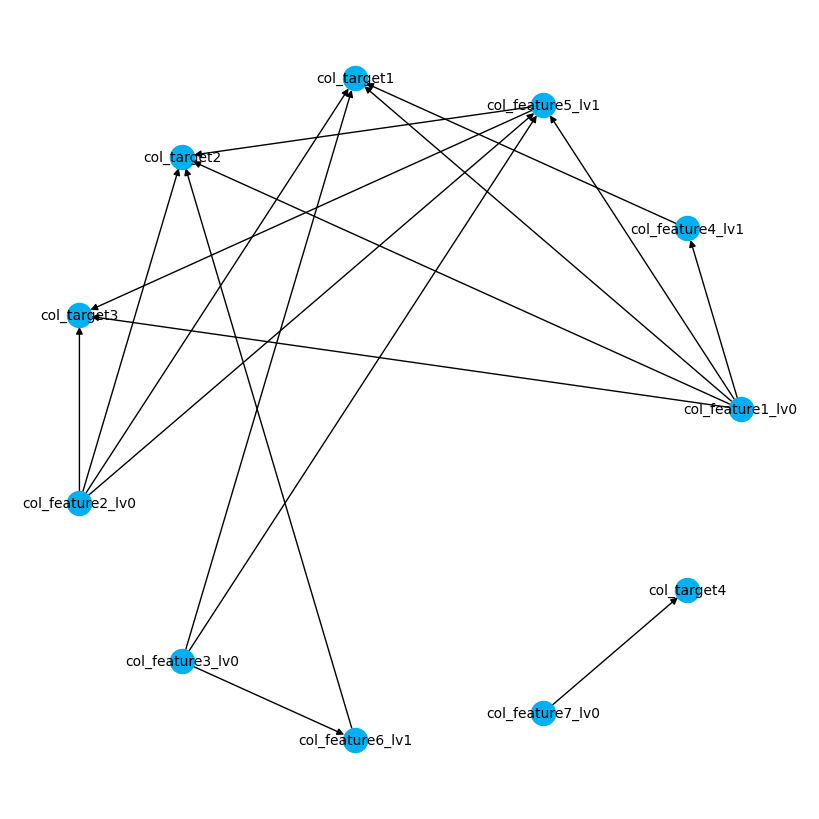

In [83]:
# larger figure size
plt.figure(3,figsize=(8,8))
pos = nx.circular_layout(graph_nx)
nx.draw(
    graph_nx,
    pos,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
plt.show()

## 3.3. Causal modeling

In [84]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Auto-assign causal mechanism (instead of manual)
gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node col_target4: 100%|██████████| 11/11 [00:00<00:00, 86.64it/s]


In [85]:
# Get arrow strength
# By default, arrow_strength employs KL divergence for measuring the arrow strength for categorical target
# Results in terms of the ouctome variable variance chnage given we remove the edge from the source variable
gcm.arrow_strength(causal_model, 'col_target4')

{('col_feature7_lv0', 'col_target4'): 6.273501571522375}

## 3.4. Estimate treatment effect

In [86]:
# Reference datapoints
X_test = df[4:5].copy().drop(columns=['col_date'])
display(X_test)
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
#dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
#dct_input_base = {col_input: lambda x: 0 for col_input in list(X_test.columns)}
dct_input = {'col_feature7_lv0': lambda x: 1}
dct_input_base = {'col_feature7_lv0': lambda x: 0}

# Average causal effect
idx_check = 3
estim_effect = gcm.average_causal_effect(
    causal_model,
    'col_target4',
    interventions_alternative=dct_input,
    interventions_reference=dct_input_base,
    observed_data=df # Using the original data
)
print(list_cols_target[idx_check])
print(y_test['col_target4'].values[0], estim_effect)

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature7_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3,col_target4
4,0.30632,0.698264,0.370721,1,0.407219,0.432159,0.355351,0.3221,0.37177,-0.058866,5.436591


col_target4
5.436591386507829 4.990105194412507
